# inisialisasi eksperimen
eksperimen variable:
- learning rate
- batch size
- epoch
- max seq len

In [2]:
# experiment parameters
LEARNING_RATE = 1e-3
EPOCH = 10
MAX_SEQ_LEN = 50
BATCH_SIZE = 1

# Loading Required Libraries

In [26]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, GRU, LSTM, Dense, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [4]:
#Colab version
from google.colab import drive
drive.mount('/content/drive')

#Path relativesBesok paginya 
path = '/content/drive/My Drive/semester 7/nlp/data_worthcheck/'

Mounted at /content/drive


In [5]:
from sklearn.preprocessing import LabelEncoder

# defining function to clean text and retrive closs-validation datasets
def cleantxt(txt):
    """
    Cleans the string passed. Cleaning Includes-
    1. remove special characters/symbols
    2. convert text to lower-case
    3. retain only alphabets
    4. remove words less than 3 characters
    5. remove stop-words
    """  
    # collecting english stop words from nltk-library
    stpw = stopwords.words('english')
    
    # Adding custom stop-words
    stpw.extend(['www','http','utc'])
    stpw = set(stpw)
    
    # using regex to clean the text
    txt = re.sub(r"\n", " ", txt)
    txt = re.sub("[\<\[].*?[\>\]]", " ", txt)
    txt = txt.lower()
    txt = re.sub(r"[^a-z ]", " ", txt)
    txt = re.sub(r"\b\w{1,3}\b", " ",txt)
    txt = " ".join([x for x in txt.split() if x not in stpw])
    return txt


def load_data():
    """
    Loads data and returns train, val, and test splits
    """

    le = LabelEncoder()
    ps_train= pd.read_csv(path+'train.csv', index_col=0)
    ps_train['label'] = le.fit_transform(ps_train['label'])

    ps_test= pd.read_csv(path+'test.csv')
    ps_test['label'] = le.fit_transform(ps_test['label'])
    
    data_train = ps_train.dropna(subset=['text_a'])
    data_train_single = data_train.drop_duplicates('text_a')

    
    X_train, X_val, y_train, y_val = train_test_split(data_train_single['text_a'], data_train_single['label'], test_size=0.4, random_state=123)
    X_test = ps_test['text_a']
    y_test = ps_test['label']
    
    return X_train, X_val, X_test, y_train, y_val, y_test


# Implementation of RNN using word embeddings using word2vec for text classification


## 1. Loading Data

In [104]:
# Load the data
X_train, X_val, X_test, y_train, y_val, y_test = load_data()

all_reviews = np.array([], dtype=str)
all_reviews = np.concatenate((all_reviews, X_train), axis=0)

In [105]:
bigrams = Phrases(sentences=all_reviews)
trigrams = Phrases(sentences=bigrams[all_reviews])

embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 139


In [102]:
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train]]
print('Convert sentences to sentences with ngrams... (done)')
MAX_REVIEW_LENGTH = 150
X_pad = pad_sequences(sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab), maxlen=MAX_REVIEW_LENGTH, padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [106]:
def build_model(embedding_matrix: np.ndarray, input_length: int,  use_lstm: bool):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    if use_lstm:
        model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    else:
        model.add(Bidirectional(GRU(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

lstm_model = build_model(embedding_matrix=trigrams_model.wv.vectors, input_length=MAX_REVIEW_LENGTH, use_lstm=True)
lstm_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_train, test_size=0.05, shuffle=True, random_state=42)

history = lstm_model.fit(x=X_train, y=y_train, validation_data=(X_train, y_train), batch_size=2000, epochs=5)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 150, 256)          35584     
                                                                 
 bidirectional_26 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_53 (Dropout)        (None, 256)               0         
                                                                 
 dense_54 (Dense)            (None, 64)                16448     
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 1)                 65        
                                                     

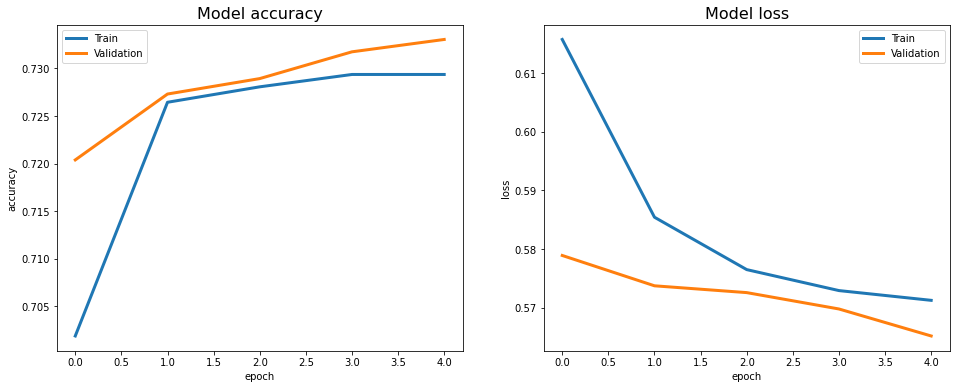

In [107]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

The AUC score of the model is : 0.6244.


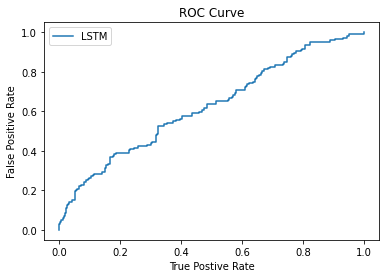

In [108]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, GRU, LSTM, Dense


y_test_pred_lstm = lstm_model.predict(X_test)

print("The AUC score of the model is : %.4f." %roc_auc_score(y_test, y_test_pred_lstm))

y_pred_list = [y_test_pred_lstm]
label_list = ["LSTM"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### 2. Tokenize text of the training data with keras text preprocessing functions ###

# Predict on test data

In [110]:
from sklearn.metrics import classification_report
# Predict on train, val and test datasets
pred_test = lstm_model.predict(X_test)
pred_test_class = [round(x[0]) for x in pred_test]

print(classification_report(y_test, pred_test_class))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       343
           1       0.67      0.12      0.21       144

    accuracy                           0.72       487
   macro avg       0.70      0.55      0.52       487
weighted avg       0.71      0.72      0.65       487

